In [1]:
!rm 2016.* # remove any downloaded data 
!wget http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2
!apt-get -qq install dtrx # download the extractor silently
!dtrx 2016.04C.multisnr.pkl.bz2

--2018-05-10 00:58:51--  http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2
Connecting to 104.197.136.14:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111458161 (106M) [application/x-bzip2]
Saving to: ‘2016.04C.multisnr.pkl.bz2’

2016.04C.multisnr.p 100%[===================>] 106.29M  62.9MB/s    in 1.7s    

2018-05-10 00:58:52 (62.9 MB/s) - ‘2016.04C.multisnr.pkl.bz2’ saved [111458161/111458161]



In [2]:
!pip install pydot # this is used to plot the neural network

## **Imports**

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, Conv2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


## **loading the data into X and their labels in the form (modulation type, snr) into a list labels**

In [0]:
with open('2016.04C.multisnr.pkl','rb') as f:
  data = pickle.load(f,encoding='bytes')

In [5]:
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
for mod_type, snr in data.keys():
  current_matrix = data[(mod_type, snr)]
  total_examples += current_matrix.shape[0]
  for i in range(current_matrix.shape[0]):
    X.append(current_matrix[i])
    labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
X = np.array(X)
labels = np.array(labels)
print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')

loaded 162060 signal vectors into X(162060, 2, 128) and their corresponding labels into labels(162060, 2)


In [6]:
data.keys()

dict_keys([(b'QPSK', 2), (b'PAM4', 8), (b'AM-DSB', -4), (b'GFSK', 6), (b'QAM64', 8), (b'AM-SSB', 12), (b'PAM4', 18), (b'QAM64', -6), (b'QAM16', 2), (b'QAM16', -20), (b'8PSK', -18), (b'PAM4', -6), (b'WBFM', -18), (b'BPSK', 8), (b'CPFSK', 10), (b'WBFM', 6), (b'BPSK', 4), (b'BPSK', -2), (b'QPSK', -20), (b'CPFSK', -8), (b'AM-SSB', 6), (b'QAM64', -20), (b'QAM16', 12), (b'GFSK', -20), (b'AM-SSB', -12), (b'CPFSK', 0), (b'AM-DSB', 6), (b'BPSK', -16), (b'QPSK', -6), (b'8PSK', -12), (b'CPFSK', -18), (b'AM-DSB', -18), (b'QPSK', 8), (b'PAM4', 14), (b'WBFM', -8), (b'AM-DSB', -10), (b'GFSK', 12), (b'QAM64', 2), (b'8PSK', -10), (b'AM-SSB', -18), (b'QAM64', -4), (b'GFSK', -4), (b'AM-DSB', 8), (b'PAM4', -16), (b'QPSK', -16), (b'BPSK', 16), (b'WBFM', -14), (b'CPFSK', 16), (b'WBFM', 0), (b'QPSK', 6), (b'BPSK', 14), (b'AM-DSB', -8), (b'GFSK', -10), (b'CPFSK', -2), (b'AM-SSB', 8), (b'QAM16', 8), (b'QAM16', 6), (b'QAM16', -16), (b'QAM64', 18), (b'AM-SSB', -2), (b'CPFSK', 6), (b'BPSK', 0), (b'BPSK', -6), (b'

## **Computing different features**

In [7]:
def apply_per_channel(X, func, verbose=False):
  X_out = np.empty_like(X)
  for i in range(X.shape[0]):
    first_channel = np.expand_dims(func(X[i][0]), axis=0) 
    second_channel = np.expand_dims(func(X[i][1]), axis=0)
    X_out[i] = np.concatenate((first_channel, second_channel), axis=0)
    if verbose:
      print(f'done with example {i}')
      
  return X_out
      

X_der = apply_per_channel(X, np.gradient)
print(f'computed derivative per channel, output shape={X_der.shape}')
  

computed derivative per channel, output shape=(162060, 2, 128)


In [8]:
# this takes some time
def antiderivative(vec):
  time_steps = np.arange(128)
  antider = UnivariateSpline(time_steps, vec).antiderivative()
  return np.array([antider(t) for t in time_steps])

  
  
X_int = apply_per_channel(X, antiderivative, False)
print(f'computed antiderivative per channel, output shape={X_int.shape}')

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
A theoretically impossible result was found during the iteration
proces for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


computed antiderivative per channel, output shape=(162060, 2, 128)


In [0]:
def get_fft_channel(X):
  cplx_X = 1j*X[:,1,:] + X[:,0,:]
  X_fft = np.empty_like(cplx_X).astype('float32')
  for i in range(X.shape[0]):
    X_fft[i] = np.absolute(np.fft.fft(cplx_X[0]))
        
  return X_fft.reshape(X_fft.shape[0], 1, X_fft.shape[1])

X_fft, freq_axis = get_fft_channel(X), np.fft.fftfreq(128)
print(f'computed the fft of the signals, X_fft{X_fft.shape}')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


computed the fft of the signals, X_fft(162060, 1, 128)


**A utility to mix features from the feature battery**

In [0]:
feature_battery = {'raw':X, 'derivative':X_der, 'integration':X_int, 'fft':X_fft}
def combine_features(*feature_names):
  return np.concatenate([feature_battery[feature] for feature in feature_names], axis=1)


**Variables used for training the models**

In [0]:
# take 20% of the data for testing and 10% of training for validation
TEST_PERCENTAGE = 0.2
VALIDATION_PERCENTAGE = 0.05

EPOCHS = 20
NUM_CLASSES = 11
BATCH_SIZE = 1024

## **Splitting the data into train, test and validation sets ** <br>
**labels is the vector of (mod_type, snr) while y is the vector of mod_types only we should train using y and then use labels to see how the classifiers performed on each of the different snr's**

In [8]:
def split_data(data, labels, percentage):
  
  split_point = int((1-percentage)*data.shape[0])
  data_train = data[0:split_point]
  data_test = data[split_point:]
  labels_train = labels[0:split_point]
  labels_test = labels[split_point:]
  y_train = labels_train[:,0]
  y_test = labels_test[:,0]
  return data_train, data_test, labels_train, labels_test, y_train, y_test


# permute the examples and their corresponding labels
idx_list = np.random.permutation(labels.shape[0]) # get a permuted index list 
X = X[idx_list]
labels = labels[idx_list]

X_train, X_test, labels_train, labels_test, y_train, y_test = split_data(X,labels, TEST_PERCENTAGE)

print(f'shapes after train test split:\n'
      f'X_train{X_train.shape}, X_test{X_test.shape}, '
      f'labels_train{labels_train.shape}, labels_test{labels_test.shape}, '
      f'y_train{y_train.shape}, y_test{y_test.shape}')


shapes after train test split:
X_train(129648, 2, 128), X_test(32412, 2, 128), labels_train(129648, 2), labels_test(32412, 2), y_train(129648,), y_test(32412,)


**Helpers for generating and plotting confusion matrices**

In [0]:
 def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(X.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix row wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[i,:]) > 0:
          confusion_mat[i,:] /= np.sum(confusion_mat[i,:])
    
    return confusion_mat,acc

**The function used to evaluate the models**

In [0]:
def evaluate_model(model, X_train, y_train, X_test, y_test, val_per, batch_size,
                   epochs, labels_test, labels, model_name):
  from IPython.display import display
  
  # get the modulation types into an array
  mod_types = np.unique(labels[:,0])
  
  # fit a label binarizer 
  mod_to_onehot = preprocessing.LabelBinarizer()
  mod_to_onehot.fit(mod_types)

  # transform the y values to one-hot encoding
  y_train = mod_to_onehot.transform(y_train)
  y_test = mod_to_onehot.transform(y_test)
  print(f'y_train{y_train.shape}')
  print(f'y_test{y_test.shape}')
  
  # train the model
  model_info = model.fit(X_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_split=VALIDATION_PERCENTAGE,
                         callbacks=[EarlyStopping(patience=1, verbose=1)])
  
  # serialize weights to HDF5
  model.save_weights(f'model-{model_name}.h5')
  print("Saved model to disk")
  
  
  # plot validation accuracy vs training accuracy
  plt.plot(np.arange(len(model_info.history['acc'])),model_info.history['acc'], '-o', label='training accuracy')
  plt.plot(np.arange(len(model_info.history['acc'])), model_info.history['val_acc'], '-o', label='validation accuracy')
  plt.legend()
  plt.xlabel('epochs')
  plt.title(f'{model_name}-validation vs training accuracy')
  display(plt.show())
  
  # plot the confussion matrix for the whole test data
  conf_mat, avg_acc = generate_confusion_matrix(model, X_test, y_test, mod_to_onehot, batch_size)
  plot_confusion_matrix(conf_mat, labels=mod_to_onehot.classes_,
                        title=f'{model_name} - conf mat for whole test data - acc={avg_acc * 100}%')
  plt.show()  
  # plot the confusion matrix per snr
  
  snr_accs = {}
  snrs = np.unique(np.unique(labels,axis=0)[:,1]).astype('int32')
  for snr in sorted(snrs):
    idx = np.where(labels_test[:,1]==str(snr))
    X_snr = X_test[idx]
    y_snr = y_test[idx]
    conf_mat, acc = generate_confusion_matrix(model, X_snr, y_snr, mod_to_onehot, batch_size)
    snr_accs[snr] = acc
    plot_confusion_matrix(conf_mat, labels=mod_to_onehot.classes_, 
                          title=f'{model_name}- Confusion Matrix (SNR={snr}) - acc={acc*100}%')
    plt.show()
    
  # plot the accuracy against the snr
  plt.plot(snr_accs.keys(),snr_accs.values(), '-o')
  plt.xlabel("Signal to Noise Ratio")
  plt.ylabel("Classification Accuracy")
  plt.xticks(list(snr_accs.keys()))
  plt.show()

## **Build and train a fully connected network as the baseline **

In [0]:
def build_cnn_net():
  reg = 1e-3
  dropout = 0.2

  cnn_model = Sequential()
  cnn_model.add(Reshape((1,X.shape[1], X.shape[2]), input_shape=(X.shape[1], X.shape[2])))
  cnn_model.add(Convolution2D(64, (1,3), padding="same", activation='relu', data_format="channels_first"))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Convolution2D(16, (2, 3), padding="same", activation='relu',data_format="channels_first"))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(reg)))
  cnn_model.add(Dropout(rate=dropout))
  cnn_model.add(Dense(NUM_CLASSES, activation='softmax'))
  cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  cnn_model.summary()
  return cnn_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 2, 128)        256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 2, 128)        512       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 2, 128)        6160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 2, 128)        512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
__________

123165/123165 [==============================] - 657s 5ms/step - loss: 5.8284 - acc: 0.3521 - val_loss: 2.4828 - val_acc: 0.4609
Epoch 2/20
123165/123165 [==============================] - 657s 5ms/step - loss: 1.9253 - acc: 0.5042 - val_loss: 2.0399 - val_acc: 0.4988
Epoch 3/20
123165/123165 [==============================] - 659s 5ms/step - loss: 1.6638 - acc: 0.5517 - val_loss: 1.6579 - val_acc: 0.5646
Epoch 4/20
 43008/123165 [=========>....................] - ETA: 6:56 - loss: 1.5849 - acc: 0.5659

123165/123165 [==============================] - 658s 5ms/step - loss: 1.5694 - acc: 0.5650 - val_loss: 1.6184 - val_acc: 0.5615
Epoch 5/20
123165/123165 [==============================] - 659s 5ms/step - loss: 1.5146 - acc: 0.5713 - val_loss: 1.4770 - val_acc: 0.5861
Epoch 6/20
123165/123165 [==============================] - 656s 5ms/step - loss: 1.4571 - acc: 0.5752 - val_loss: 1.4274 - val_acc: 0.5754
Epoch 7/20
 39936/123165 [========>.....................] - ETA: 7:11 - loss: 1.4211 - acc: 0.5815

123165/123165 [==============================] - 655s 5ms/step - loss: 1.3969 - acc: 0.5827 - val_loss: 1.3660 - val_acc: 0.5865
Epoch 8/20
123165/123165 [==============================] - 656s 5ms/step - loss: 1.3669 - acc: 0.5887 - val_loss: 1.3517 - val_acc: 0.5866
Epoch 9/20
123165/123165 [==============================] - 658s 5ms/step - loss: 1.3490 - acc: 0.5912 - val_loss: 1.3225 - val_acc: 0.5905
Epoch 10/20
 39936/123165 [========>.....................] - ETA: 7:12 - loss: 1.3351 - acc: 0.5982

123165/123165 [==============================] - 657s 5ms/step - loss: 1.3332 - acc: 0.5957 - val_loss: 1.3030 - val_acc: 0.5973
Epoch 11/20
123165/123165 [==============================] - 657s 5ms/step - loss: 1.3143 - acc: 0.5999 - val_loss: 1.3334 - val_acc: 0.5988
Epoch 00011: early stopping
Saved model to disk


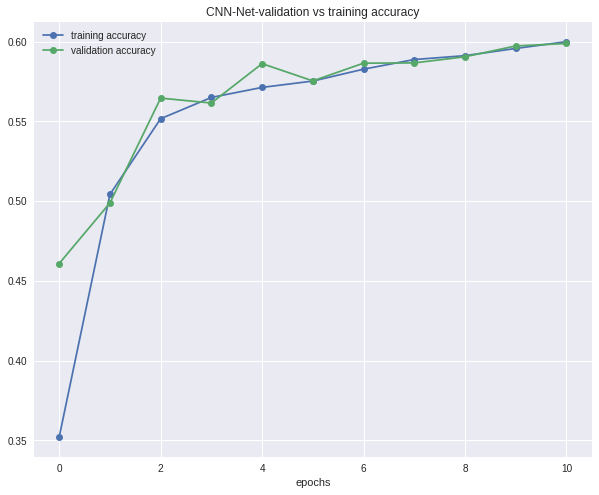

None

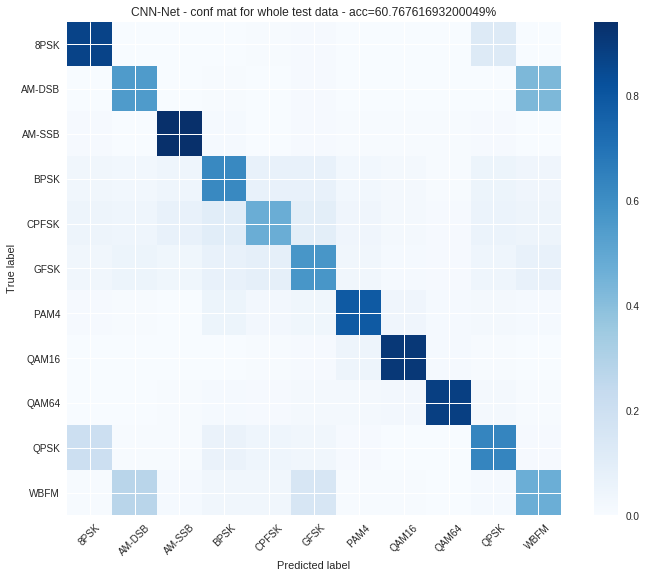

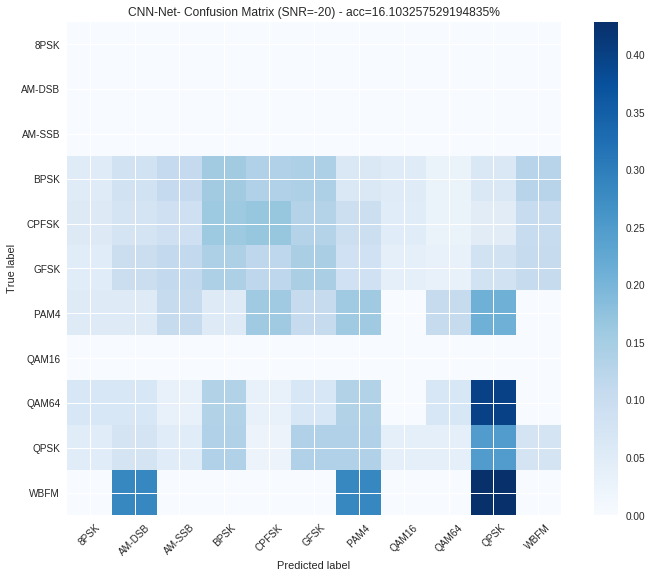

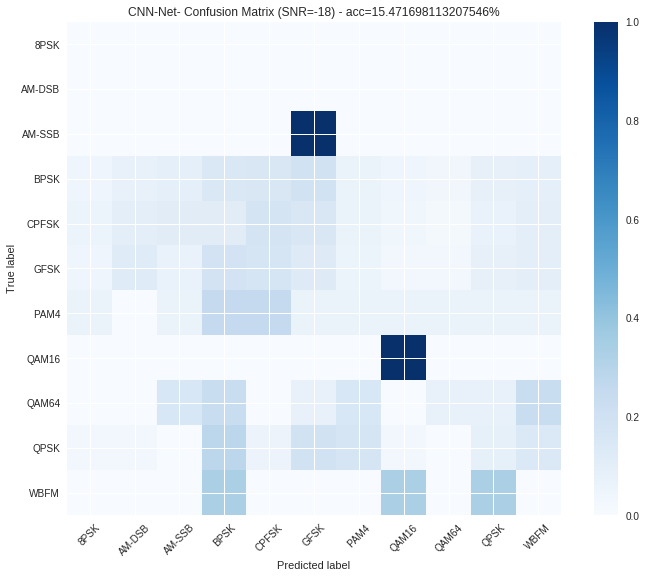

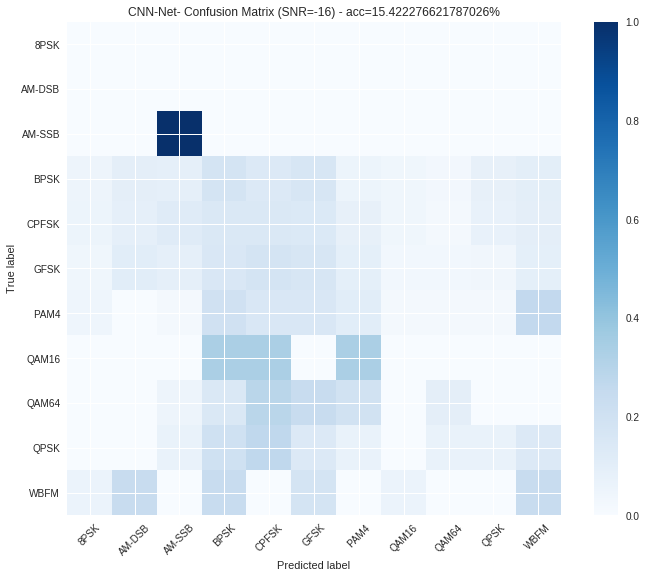

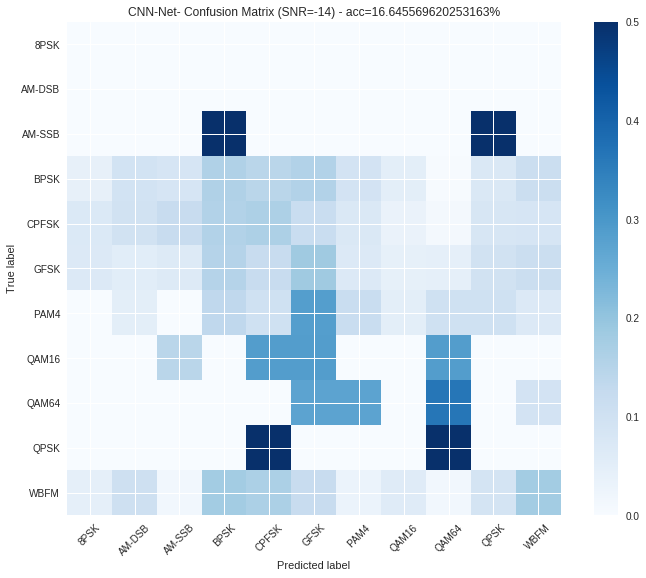

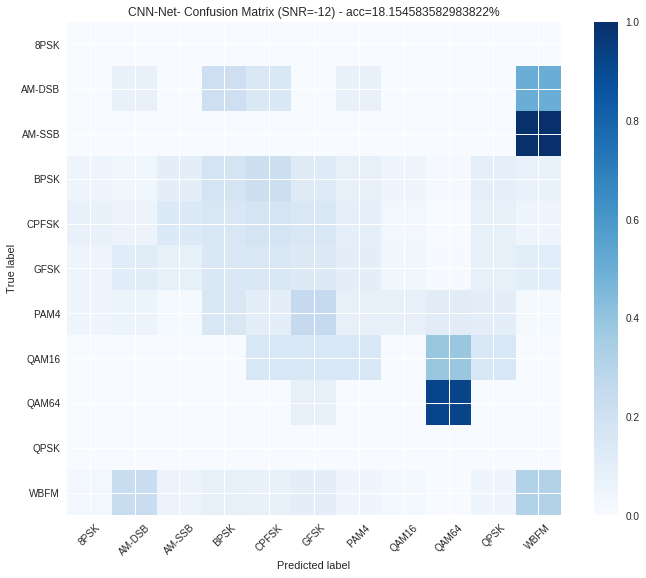

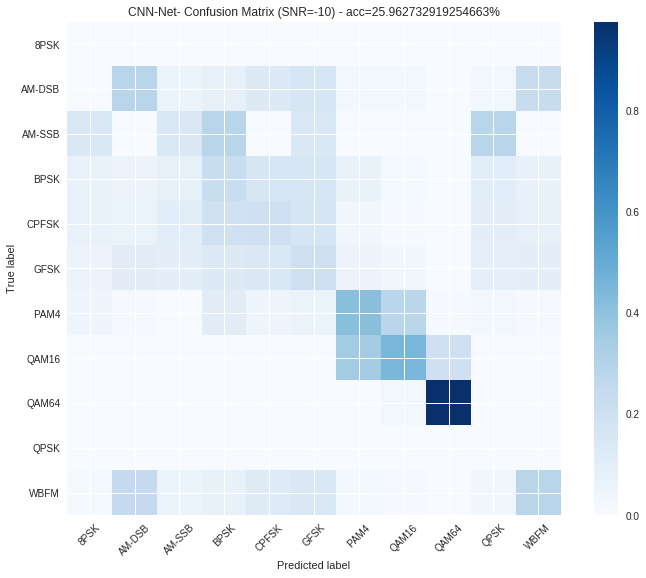

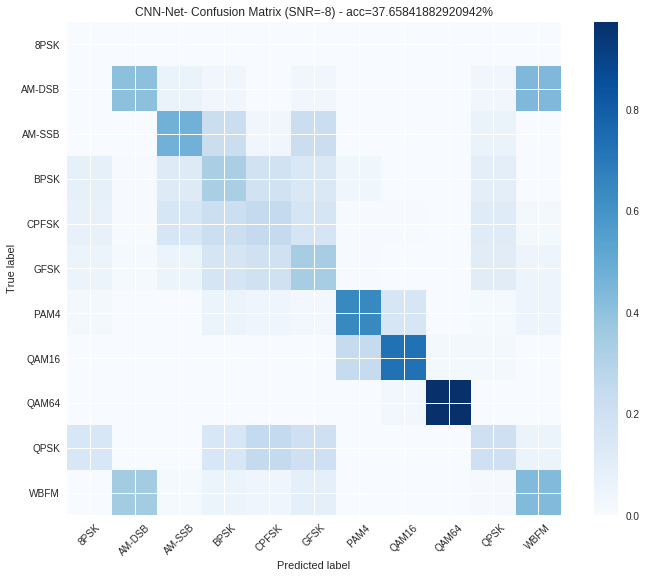

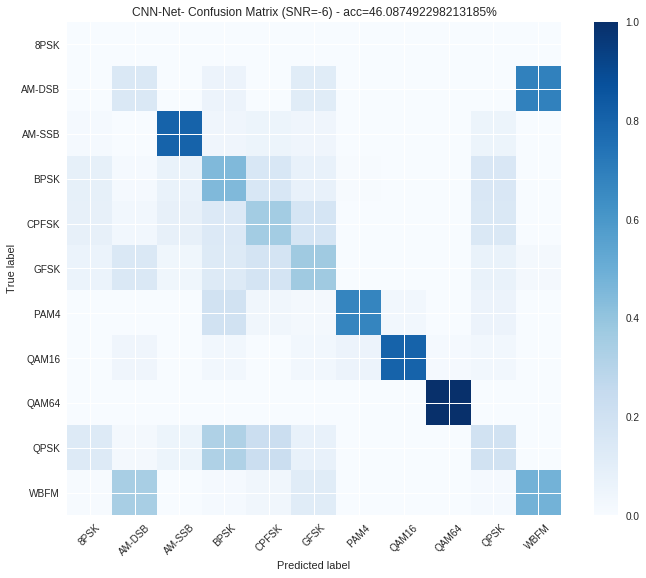

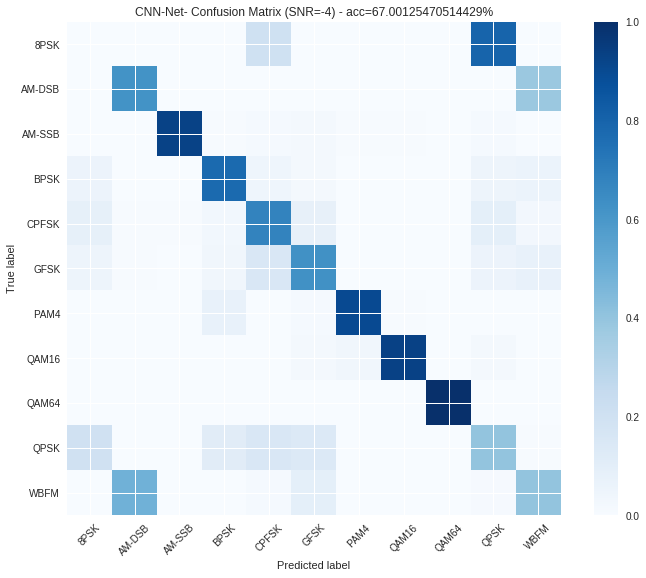

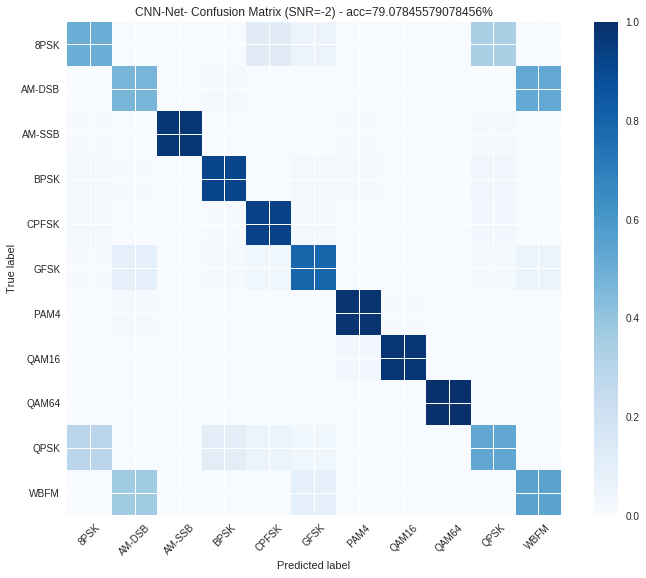

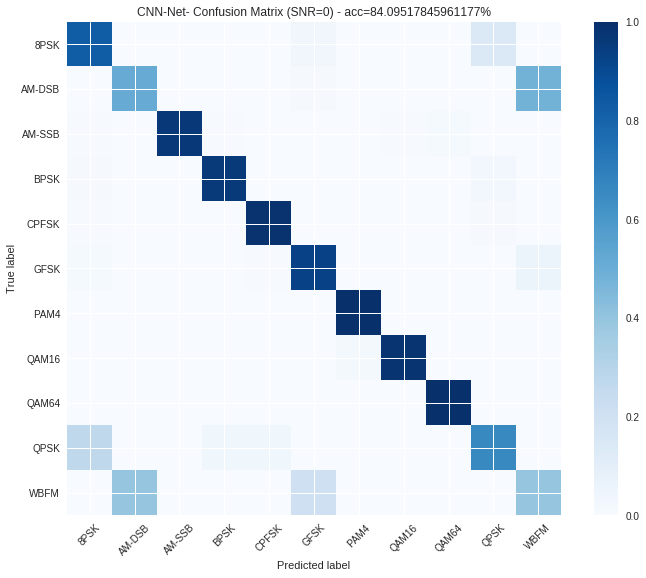

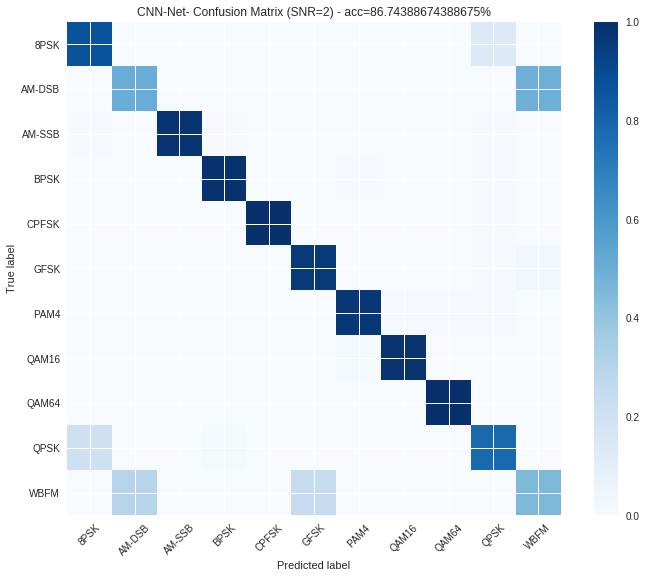

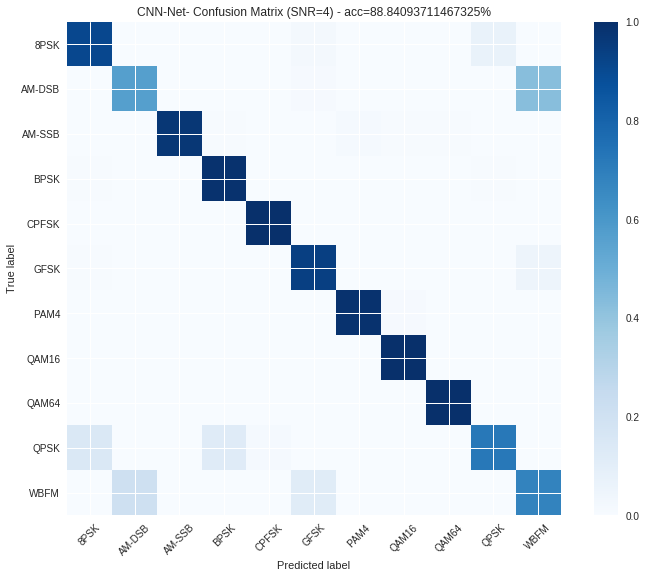

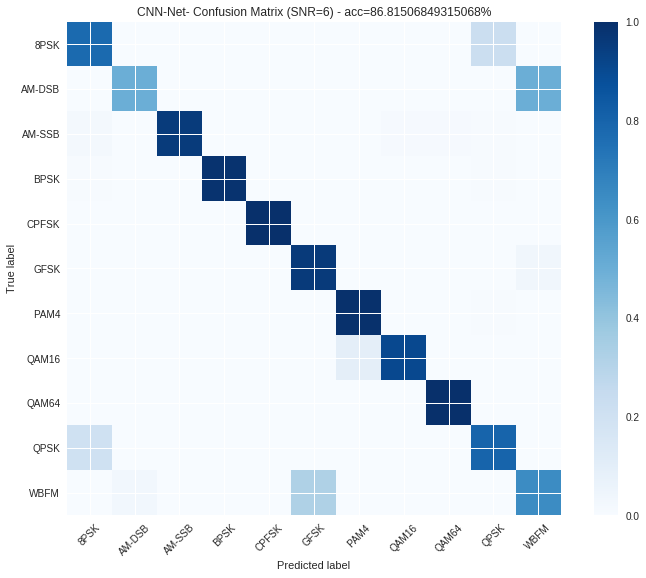

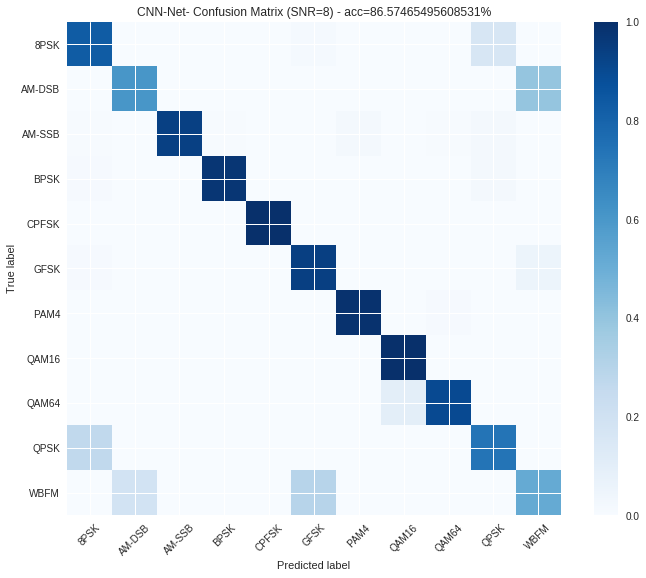

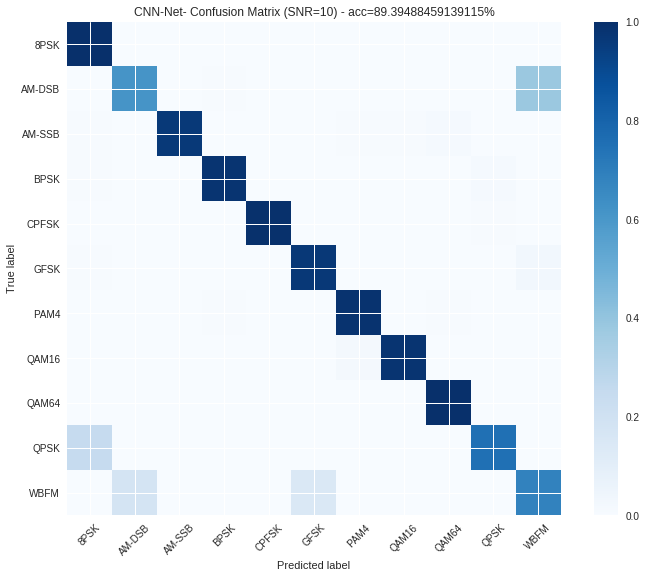

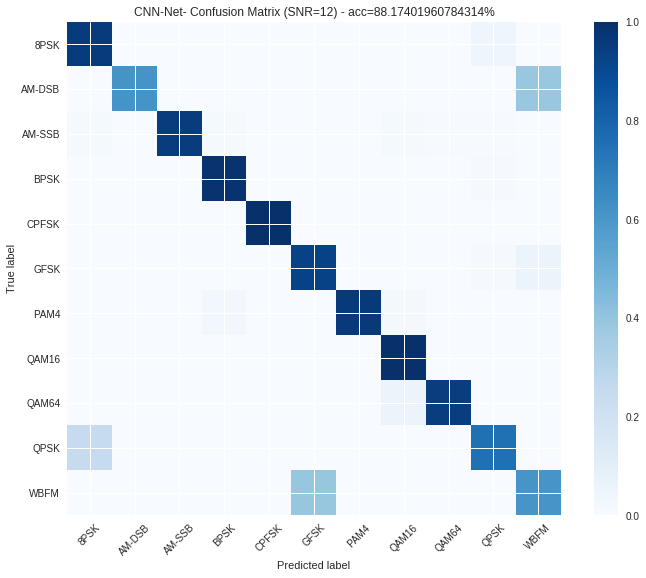

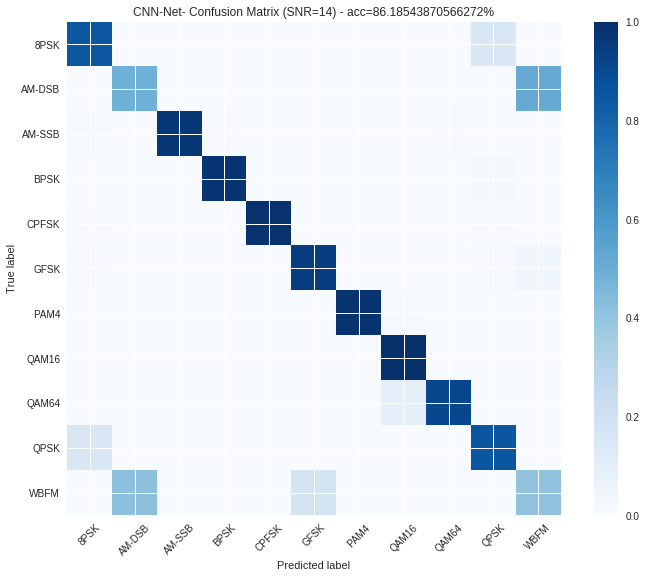

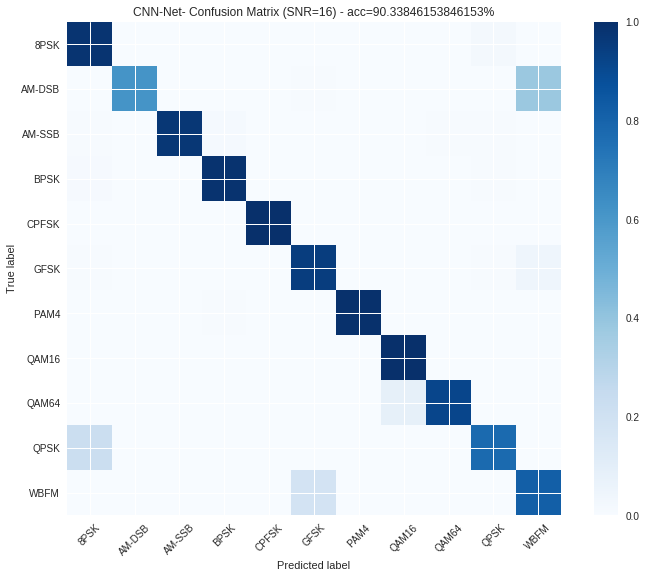

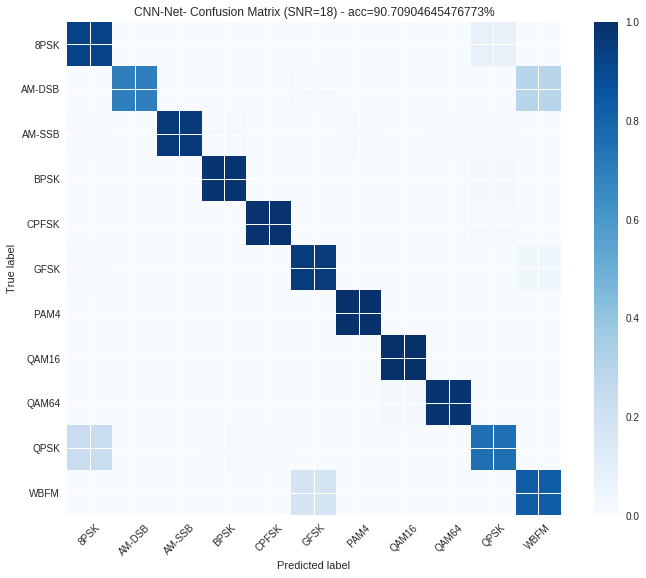

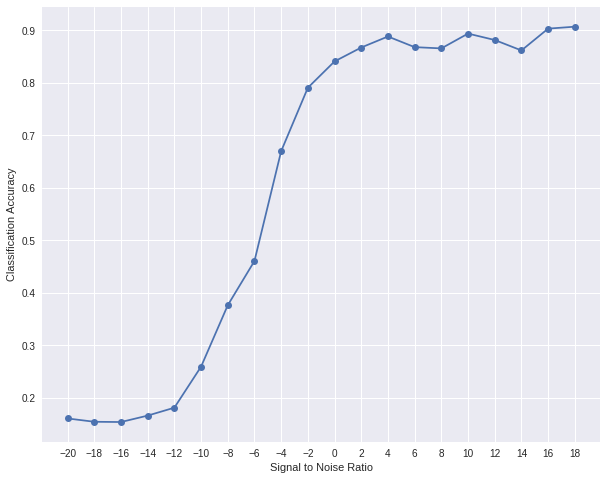

In [15]:
model = build_cnn_net()
evaluate_model(model, X_train, y_train, X_test, y_test, VALIDATION_PERCENTAGE, BATCH_SIZE, 20, labels_test, labels, 'CNN-Net')

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cnn).create(prog='dot', format='svg'))